In [ ]:
from google.colab import drive # Mount the google drive for data loading
drive.mount('/content/drive')

Mounted at /content/drive


# Import some related dependencies
1.   Numpy: a package for array transformation
2.   Pandas: a package for loading data with .csv/.xlsx formats
3.   Matplotlib: a package for data visualization
4.   Skearn: a package including many machine learning approaches
5.   Tensorflow: a package for neural networks modeling
5.   Keras: a package for neural networks modeling which is established on Tensorflow

In [ ]:
import numpy as np #helps for array operation
import pandas as pd #helps to read the data
import matplotlib.pyplot as plt #helps with graphical plots
from sklearn.preprocessing import MinMaxScaler #helps for normalization of input data 
import keras            #helps for CNN model construction
import tensorflow as tf #helps for CNN model construction

# Load data using Pandas package

1.   Data visualization 
2.   Data segmentation
3.   Training data and testing data split 

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/lab_code/Stock.csv')  #Load data with the corresponding path in google drive 

In [ ]:
data.head()

,date,item_cnt_day
0,2013-01-01,1951.0
1,2013-01-02,3817.0
2,2013-01-03,3846.0
3,2013-01-04,2574.0
4,2013-01-05,4863.0


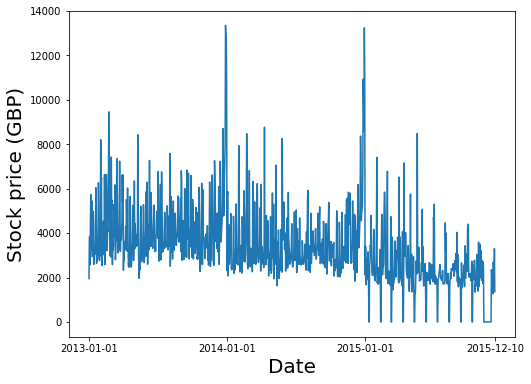

In [ ]:
# Visualization 
plt.figure(figsize=(8,6))
plt.plot(data['date'], data['item_cnt_day'])
plt.xticks(['2013-01-01','2014-01-01','2015-01-01','2015-12-10'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Stock price (GBP)', fontsize=20)
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))                                     # Normalization step, the output will be scaled to [-1,1]
scaled_price = scaler.fit_transform(data['item_cnt_day'].values.reshape(-1,1))  # Data Normalization

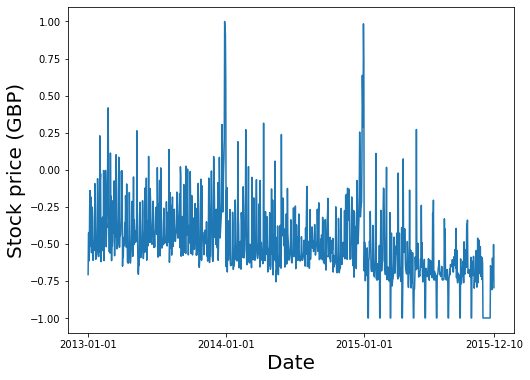

In [ ]:
# Visualization of scaled data
plt.figure(figsize=(8,6))
plt.plot(data['date'], scaled_price)
plt.xticks(['2013-01-01','2014-01-01','2015-01-01','2015-12-10'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Stock price (GBP)', fontsize=20)
plt.show()

In [ ]:
# Segment data using sliding windows
X, Y = [], []   
timestep = 30                                       # Sliding window size
k = 850                                             # The threshold for the training set and the testing set
for i in range(len(scaled_price)- timestep):        # Data Segmentation.
  X.append(scaled_price[i:i+timestep])
  Y.append(scaled_price[i+timestep])
X=np.asarray(X)
Y=np.asarray(Y)

# Training data and testing data split
X_train = X[:k,:,:]                                 # Training data
y_train = Y[:k]                                     # Training labels

X_test = X[k:,:,:]                                  # Testing data
y_test = Y[k:]                                      # Testing labels

print (X_train.shape)
print (X_test.shape)

(850, 30, 1)
(194, 30, 1)


In [ ]:
X_train = np.expand_dims(X_train, axis=2) # Add a dimension for each training sample - 1 x 30 x 1 x 1
X_test = np.expand_dims(X_test, axis=2)   # Add a dimension for each testing sample - 1 x 30 x 1 x 1
print (X_train.shape)
print (X_test.shape)

(850, 30, 1, 1)
(194, 30, 1, 1)


# Model training

In [ ]:
# LeNet-5 model for model training
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=6, kernel_size=(5,1), strides=(1,1), padding='same', activation='relu', input_shape=(30, 1, 1)))  # The first convolutional layer. Input shape is 8x1x1 and activation function is Rectified Linear Unit (ReLU).\
                                                           # Kernel size and stride are set as (5,1) and (1,1), respectively. The number of convolutional kernels is 6. Besides, the zero padding is 'same', thus the output shape is (30/1) x 1 x 6 = 30x1x6, which is the same as the input shape.
model.add(keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))  # The first maxpooling layer. The pool size and stride are both (2,1), thus the output shape is 15x1x6, where 15 = (30-2)/2 + 1.
model.add(keras.layers.Conv2D(filters=16, kernel_size=(5,1), strides=(1,1), activation='relu')) # The second convolutional layer. The output shape is 11x1x16, where 11 = (15-5)/1 + 1.
model.add(keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))  # The second maxpooling layer. The pool size and stride are both (2,1). The output shape is 5x1x16, where 5 = ⌊(11-2)/2⌋+1.
model.add(keras.layers.Flatten())                          # The previous output is flattened to be a vector.
model.add(keras.layers.Dense(120, activation='relu'))      # The first fully connected layer.
model.add(keras.layers.Dropout(0.2))                       # Dropout layer
model.add(keras.layers.Dense(84, activation='relu'))       # The second fully connected layer.
model.add(keras.layers.Dropout(0.2))                       # Dropout layer
model.add(keras.layers.Dense(1))                           # we have 1 neuron for output (Price).
model.summary()                                            # Summary the constructed model. 
model.compile(tf.keras.optimizers.Adam(learning_rate = 1e-3), 'mean_squared_error') # Model construction with a SGD optimizer and a mean squared error loss function.
model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 2, validation_data = (X_test, y_test))    # Model training with some hyperparameters.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 1, 6)          36        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 1, 6)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 1, 16)         496       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 1, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 120)               9

# Model testing

In [ ]:
scaled_preds = model.predict(X_test)                    # Prediction of testing set.     
preds = scaler.inverse_transform(scaled_preds)          # Inverse the prediction values, because the predicted values are in [-1,1].
ytest = scaler.inverse_transform(y_test.reshape(-1,1))  # Inverse the actual values.

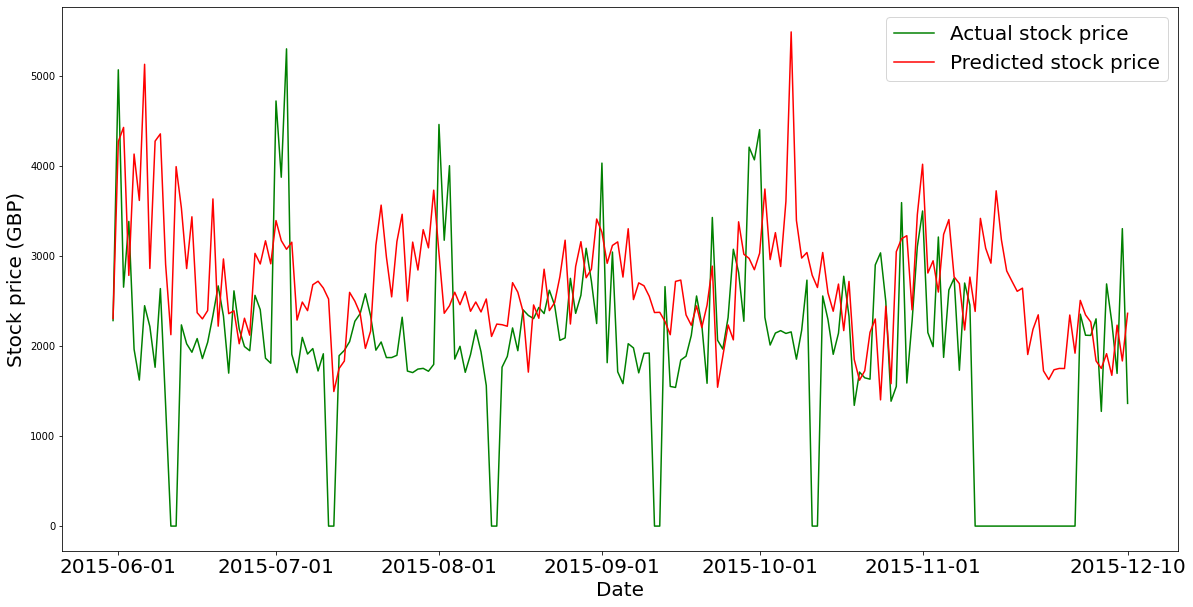

In [ ]:
# Visualization of predicted stocks and actual stocks
plt.figure(figsize=(20,10))
plt.plot(data['date'].iloc[k+timestep:], ytest, c = 'g', label = 'Actual stock price')
plt.plot(data['date'].iloc[k+timestep:], preds, c = 'r', label = 'Predicted stock price')
plt.xticks(['2015-06-01','2015-07-01','2015-08-01','2015-09-01','2015-10-01','2015-11-01','2015-12-10'], fontsize = 20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Stock price (GBP)', fontsize=20)
plt.legend(fontsize=20)
plt.show()